# Random Graphs

The goal of this notebook is to explore some of theory behind Erdös-Rényi random binomial graphs and propose extensions to the methodology to model heterogeneous networks. Hopefully, some of this will be useful for understanding how the properties of networks of biological data change when they are integrated.

In [1]:
import networkx as nx

import numpy as np
from numpy.random import uniform

import itertools as itt
from itertools import compress, combinations, product

import pandas as pd
import scipy as scp
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 9.0)
np.random.seed(seed=127)

# Example 1: Small Erdös-Rényi Graph

This example shows an Erdös-Rényi random binomial graph $G(n, p)$ over $n$ nodes where an edge is added with uniform probability $p$ for each of the $n \choose 2$ possible edges.

$P(deg(v)=k)={n-1 \choose k}p^k(1-p)^{n-1-k} \sim Binomial(n,p)$

For large $n$, $Binomial(n,p) \approx \mathcal{N}(\mu = np, \sigma = \sqrt{np(1-p)})$.

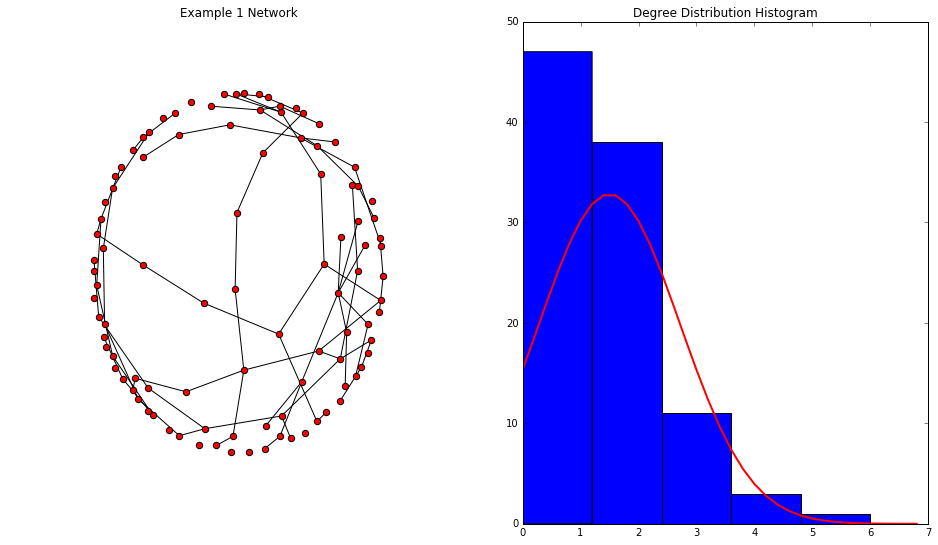

In [2]:
n = 100
p = 0.015

nodes = np.arange(n)
edges = compress(combinations(nodes, 2), uniform(size=int(n * (n - 1) / 2)) < p)

g = nx.Graph()

for node in nodes:
    g.add_node(node)

for edge in edges:
    g.add_edge(*edge)

pos = nx.spring_layout(g)


f, ax = plt.subplots(1, 2)

nx.draw(g, pos, node_size=40, ax=ax[0])
ax[0].set_title("Example 1 Network")

d = list(g.degree().values())
ax[1].hist(d, bins=5)
#ax[1].axvline(np.average(d), color='red', linewidth=4)
ax[1].set_title("Degree Distribution Histogram")

# Plot theoretical distribution FIXME
t1 = np.arange(min(d), max(d) + 1, 0.2)
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
ax[1].plot(t1, n * stats.norm.pdf(t1, mu, sigma), linewidth=2, color='r')

# Example 2: Small Heterogeneous Network

This static example visualizes what it might be like to have a heterogeneous network with Red entities and Blue entities. 

Each the Red and Blue entities come from their own networks with Red-Red and Blue-Blue connections. This example shows a data integration effort that uses Red-Blue edges (colored in purple) to connect the two networks.

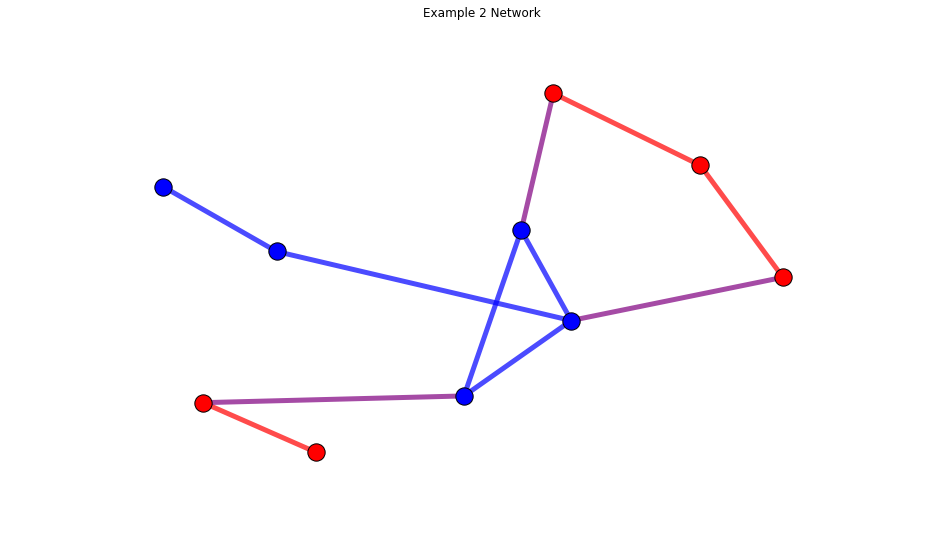

In [3]:
red = ["a", "b", "c", "d", "e"]
blue = ["1", "2", "3", "4", "5"]

rr = [("a", "b"), ("b", "c"), ("d", "e")]
rb = [("1", "d"), ("2", "c"), ("3", "a")]
bb = [("1", "2"), ("2", "3"), ("1", "3"), ("3", "4"), ("4", "5")]

g = nx.Graph()
for node in itt.chain(red, blue):
    g.add_node(node)
for edge in itt.chain(rr, bb, rb):
    g.add_edge(*edge)
    
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=red, node_color='red')
nx.draw_networkx_nodes(g, pos, nodelist=blue, node_color='blue')
nx.draw_networkx_edges(g, pos, edgelist=rr, alpha=0.7, width=5, edge_color='red')
nx.draw_networkx_edges(g, pos, edgelist=bb, alpha=0.7, width=5, edge_color='blue') 
nx.draw_networkx_edges(g, pos, edgelist=rb, alpha=0.7, width=5, edge_color='purple')
plt.axis('off')
plt.title("Example 2 Network")
plt.show()

# Example 3: Simple Heterogeneous Network

This heterogeneous network wil contain two classes, $A=\{a_1 \dots a_n\}$ and $B=\{b_1 \dots b_m\}$

## Edge Choices

Edges will be chosen randomly as follows:
- $P(\{a_1,a_2\} \in E) \sim Uniform(p_{a,a}) \quad a_1,a_2 \in A$ 
- $P(\{b_1,b_2\} \in E) \sim Uniform(p_{b,b}) \quad b_1,b_2 \in B$ 
- $P(\{a, b\} \in E) \sim Uniform(p_{a,b}) \quad a\in A, b \in B$ 

## Expected Number of Edges

- A-A expects ${|A| \choose 2} * p_{a,a}$
- B-B expects ${|B| \choose 2} * p_{b,b}$
- A-B expects $|A| * |B| * p_{a,b}$

This situation returns to the traditional random binomial graph over $G(m+n, p)$ when $p=p_{a,a}=p_{a,b}=p_{b,b}$ 

Total Expected Edges = ${n \choose 2} * p_{a,a} + {m \choose 2} * p_{b,b} + nm * p_{a,b}$

## Degree Distribution

We're taking advantage of the fact that each of these parts were chosen randomly from different distributions.


### Membership in Classes within Network
$P(v \in A) = \frac{|A|}{|A| + |B|} = \frac{n}{n+m}$

$P(v \in B) = \frac{|B|}{|A| + |B|} = \frac{m}{n+m}$

$1 = P(v \in B) + P(v \in A) = \frac{n}{n+m} + \frac{m}{n+m}$

### Given $v \in A$

$P(deg_A(v)=k \mid v \in A)={|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k}$

$P(deg_B(v)=k \mid v \in A)={|B| \choose k}p_{ab}^k(1-p_{ab})^{|B|-k}$

### Given $v \in B$

$P(deg_A(v)=k \mid v \in B)={|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k}$

$P(deg_B(v)=k \mid v \in B)={|B|-1 \choose k}p_{bb}^k(1-p_{bb})^{|B|-1-k}$

### Combine
How can we combine these to get the whole distribution over $deg_A(v)$ and eventually the joint distribution $deg(v)=deg_A(v)+deg_B(v)$

Using the Law of Total Probability $P(A)=\sum \limits_{n}P(A \mid B_n)*P(B_n)$ when all the possible $B_n$'s make up the whole sample space, it can be applied:

$P(deg_A(v)=k) = P(deg_A(v)=k \mid v \in A)*P(v \in A) + P(deg_A(v)=k \mid v \in B)*P(v \in B)\\={|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k}*\frac{n}{n+m} + {|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k}*\frac{m}{n+m}$

and similarly:

$P(deg_B(v)=k) = P(deg_B(v)=k \mid v \in A)*P(v \in A) + P(deg_B(v)=k \mid v \in B)*P(v \in B)\\={|B| \choose k}p_{ab}^k(1-p_{ab})^{|B|-k}*\frac{n}{n+m} + {|B|-1 \choose k}p_{bb}^k(1-p_{bb})^{|B|-1-k}*\frac{m}{n+m}$

### Goals Equations/Values
- $P(deg_A(v)=k, deg_B(v)=l)=P(deg_A(v)=k, deg_B(v)=l \mid v \in A)*P(v \in A)+P(deg_A(v)=k, deg_B(v)=l \mid v \in B)*P(v \in B)$
- $P(deg(v)=k)=\sum\limits_{r=0}^k P(deg_A(v)=k-r, deg_B(v)=r)$



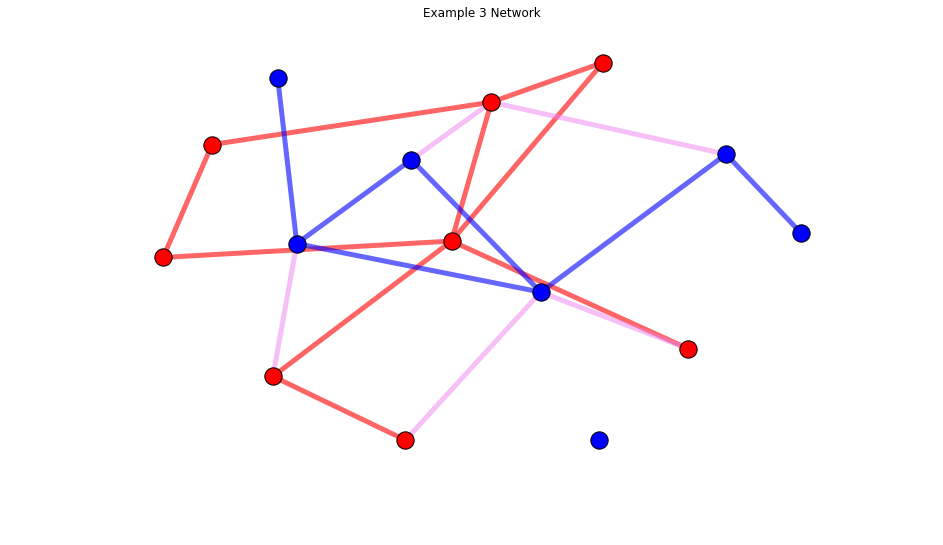

In [4]:
# represent class sizes as array
n_r, n_b = 8, 7
# represent probabilities as squashed upper triangular matrix
p_rr, p_rb, p_bb = 0.30, 0.15, 0.25

r = list(range(n_r))
b = list(range(n_r, n_r + n_b))

rr_dist = np.random.uniform(size=int(n_r * (n_r - 1) / 2)) 
bb_dist = np.random.uniform(size=int(n_b * (n_b - 1) / 2))
rb_dist = np.random.uniform(size=(n_b * n_r))

rr_edges = list(itt.compress(itt.combinations(r, 2), rr_dist < p_rr))
bb_edges = list(itt.compress(itt.combinations(b, 2), bb_dist < p_bb))
rb_edges = list(itt.compress(itt.product(r, b), rb_dist < p_rb))

g = nx.Graph()

for node in itt.chain(r, b):
    g.add_node(node)

for edge in itt.chain(rr_edges, bb_edges, rb_edges):
    g.add_edge(*edge)
    
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, nodelist=r, node_color='r')
nx.draw_networkx_nodes(g, pos, nodelist=b, node_color='b')

nx.draw_networkx_edges(g, pos, edgelist=rr_edges, width=5, alpha=0.6, edge_color='red')
nx.draw_networkx_edges(g, pos, edgelist=bb_edges, width=5, alpha=0.6, edge_color='blue') 
nx.draw_networkx_edges(g, pos, edgelist=rb_edges, width=5, alpha=0.5, edge_color='violet') 

plt.title("Example 3 Network")
plt.axis('off')
plt.show()

# Example 4: Arbitrary Number of Classes

Given ${n}$ classes, there are $n$ integer parameters for class sizes, $n$ double parameters for self probabilities, and ${n \choose 2}$ double parameters for cross probabilities for a total ot $2n + {n \choose 2}$ parameters

In [26]:
class_sizes = [500, 500]
class_colors = ["red", "blue"]

# the diagonal of the probability matrix
p_self = [0.30, 0.30]

# the row vector representing the upper right triangular part of the probability matrix
# should contain |n| choose 2 entries
p_cross = [0.3] 

node_groups = []
prev = 0
for i in np.cumsum(class_sizes):
    node_groups.append(list(range(prev, i)))
    prev = i

singl_edge_sets = []
for class_index, class_size in enumerate(class_sizes):
    dist_size = int(class_size * (class_size - 1) / 2)
    dist = uniform(size=dist_size)
    threshold = dist < p_self[class_index]
    combs = combinations(node_groups[class_index], 2)
    singl_edge_sets.append(list(compress(combs, threshold)))

cross_edge_sets = []
for i, class_pair in enumerate(combinations(range(len(class_sizes)), 2)):
    c1, c2 = class_pair
    cross_size = class_sizes[c1] * class_sizes[c2]
    distribution = uniform(size=cross_size)
    threshold = distribution < p_cross[i]
    cross = product(node_groups[c1], node_groups[c2])
    cross_edge_sets.append(list(compress(cross, threshold)))

g = nx.Graph()

for node_group_index, node_group in enumerate(node_groups):
    for node in node_group:
        g.add_node(node, color=class_colors[node_group_index], class_index=node_group_index)

for i, single_edge_set in enumerate(singl_edge_sets):
    for edge in single_edge_set:
        g.add_edge(*edge, label={i}, note="self")

for cross_edge_set, class_pair in zip(cross_edge_sets, combinations(range(len(class_sizes)), 2)):
    c1, c2 = class_pair
    for edge in cross_edge_set:
        g.add_edge(*edge, label={c1, c2}, note="cross")

## Degree Distribution

What do the degree distributions look like for each node?

The distributions by themselves are bimodal, but this is a misrepresentation of data since they are chosen together. 

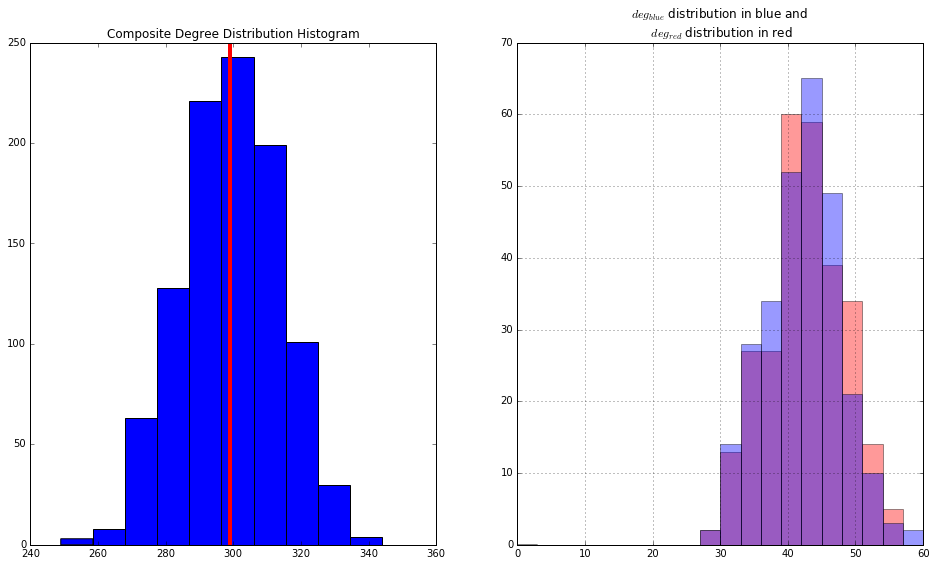

In [27]:
f, ax = plt.subplots(1, 2)

d = list(nx.degree(g).values())
ax[0].hist(d)
ax[0].set_title("Composite Degree Distribution Histogram")
ax[0].axvline(np.average(d), color='red', linewidth=4)

max_degrees = degrees.max().max()
for color in class_colors:
    degrees[color].hist(alpha=0.4, color=color, bins=20, range=(0, max_degrees), ax=ax[1])
ax[1].set_title("$deg_{blue}$ distribution in blue and \n $deg_{red}$ distribution in red")

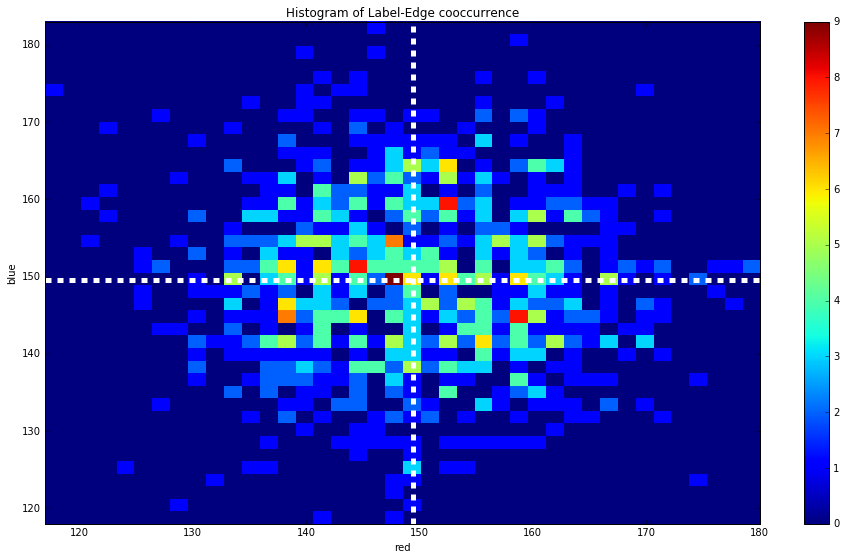

In [28]:
# calculate degrees dictionary node:{c1:X, c2:Y, c3:Z}
degrees = {node: [0 for c in range(len(class_sizes))] for node in g.nodes()}
for edge in g.edges(data=True):
    n1, n2, data = edge
    degrees[n1][g.node[n2]['class_index']] += 1
    degrees[n2][g.node[n1]['class_index']] += 1

    
cnames = ["{}:{}".format(i, g.node[i]['color']) for i in g.nodes()]
degrees = pd.DataFrame(degrees, index=class_colors).T

plt.hist2d(degrees.values[:,0], degrees.values[:,1], bins=40)
plt.colorbar()
plt.xlabel(class_colors[0])
plt.axvline(np.average(degrees.values[:,0]), color='white', linewidth=5, ls="dashed")
plt.axhline(np.average(degrees.values[:,1]), color='white', linewidth=5, ls="dashed")
plt.ylabel(class_colors[1])
plt.title("Histogram of deg_red and deg_blue cooccurrence")
plt.show()

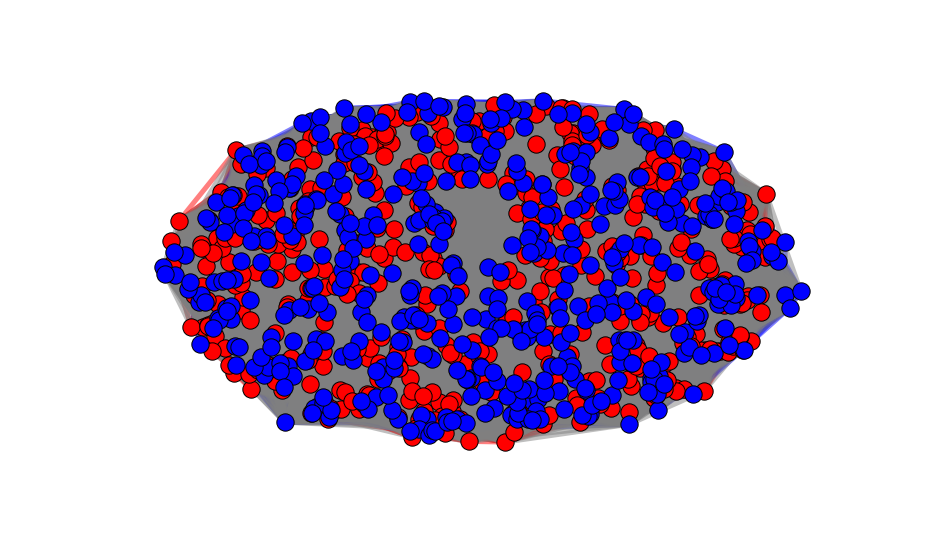

In [29]:
pos = nx.spring_layout(g, iterations=100)

for node_group, color in zip(node_groups, class_colors):
    nx.draw_networkx_nodes(g, pos, nodelist=node_group, node_color=color)

for singl_edge_set, color in zip(singl_edge_sets, class_colors):
    nx.draw_networkx_edges(g, pos, edgelist=singl_edge_set, width=5, alpha=0.5, edge_color=color)
    
for cross_edge_set in cross_edge_sets:
    nx.draw_networkx_edges(g, pos, edgelist=cross_edge_set, width=5, alpha=0.5, edge_color='grey') 

plt.axis('off')
plt.title("Example 4 Network")
plt.show()

# References
- https://networkx.github.io/documentation/latest/examples/drawing/labels_and_colors.html